In [1]:
import os
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

2025-03-26 21:13:39.125532: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-26 21:13:40.485179: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


scanpy==1.10.4 anndata==0.11.3 umap==0.5.6 numpy==1.26.4 scipy==1.13.0 pandas==2.2.3 scikit-learn==1.4.2 statsmodels==0.14.4 igraph==0.11.8 pynndescent==0.5.12


In [2]:
ROOT_DIR = '/work/hdd/bbjr/mallina1/data/human_cellariumgpt_v2/assay_conversion'
# ROOT_DIR = '/work/hdd/bbjr/mallina1/data/human_cellariumgpt_v2/assay_conversion2'

# INP_DIRS = [
#     '2025_03_21_20_15_convert_to_10x_Chromium_v3',
#     '2025_03_21_23_00_convert_to_10x_Chromium_v2_A',
#     '2025_03_22_23_42_convert_to_10x_Chromium_v2_A', # fixed sort index, using fixed_gene_list
#     '2025_03_23_06_35_convert_to_10x_Chromium_v2_A', # fixed sort index, not using fixed_gene_list
#     '2025_03_24_18_35_convert_to_10x_Chromium_v3', # use categorical with probs = logits.exp(),
#     '2025_03_24_19_36_convert_to_10x_Chromium_v3', # no batch inference, restrict adata to 10x v3 ,
#     '2025_03_24_20_26_convert_to_10x_Chromium_v3', # no batch inference, not using isin but rather directly indexing adata
#     '2025_03_24_21_24_convert_to_10x_Chromium_v3', # batch inference, directly indexing, 8000 cells
# ]
# INP_DIRS = [
#     '2025_03_25_02_54_convert_to_10x_Chromium_v3',
#     '2025_03_25_02_41_convert_to_10x_Chromium_v3',
#     '2025_03_25_14_32_convert_to_10x_Chromium_v3',
#     '2025_03_25_16_22_convert_to_10x_Chromium_v3',
#     '2025_03_25_16_44_convert_to_10x_Chromium_v3',
#     '2025_03_25_17_25_convert_to_10x_Chromium_v3',
#     '2025_03_26_13_50_convert_to_10x_Chromium_v3',
#     '2025_03_26_14_42_convert_to_10x_Chromium_v3'
# ]
# INP_DIR = INP_DIRS[-1]

INP_DIR = max((d for d in os.listdir(ROOT_DIR) if os.path.isdir(os.path.join(ROOT_DIR, d))), key=lambda x: os.path.getctime(os.path.join(ROOT_DIR, x)))
print(INP_DIR)

2025_03_26_21_12_convert_to_10x_Chromium_v3


In [3]:
orig_adata = sc.read_h5ad(os.path.join(ROOT_DIR, INP_DIR, 'original.h5ad'))
conv_adata = sc.read_h5ad(os.path.join(ROOT_DIR, INP_DIR, 'converted.h5ad'))

orig_adata

AnnData object with n_obs × n_vars = 960 × 4096
    obs: 'NAME', 'nGene', 'nUMI', 'percent.mito', 'Cluster', 'CellType', 'Experiment', 'Method', 'assay', 'assay_ontology_term_id', 'suspension_type', 'total_mrna_umis', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'skipped_row'
    var: 'gene_symbols'
    uns: 'CellType_colors', 'Method_colors'
    obsm: 'X_harmony'

In [4]:
# Omit rows that were skipped during the conversion process
orig_adata = orig_adata[orig_adata.obs.skipped_row == False]
conv_adata = conv_adata[conv_adata.obs.skipped_row == False]

orig_adata

View of AnnData object with n_obs × n_vars = 960 × 4096
    obs: 'NAME', 'nGene', 'nUMI', 'percent.mito', 'Cluster', 'CellType', 'Experiment', 'Method', 'assay', 'assay_ontology_term_id', 'suspension_type', 'total_mrna_umis', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'skipped_row'
    var: 'gene_symbols'
    uns: 'CellType_colors', 'Method_colors'
    obsm: 'X_harmony'

In [5]:
conv_adata

View of AnnData object with n_obs × n_vars = 960 × 4096
    obs: 'NAME', 'nGene', 'nUMI', 'percent.mito', 'Cluster', 'CellType', 'Experiment', 'Method', 'assay', 'assay_ontology_term_id', 'suspension_type', 'total_mrna_umis', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'skipped_row'
    var: 'gene_symbols'
    uns: 'CellType_colors', 'Method_colors'
    obsm: 'X_harmony'

In [6]:
(orig_adata.var_names == conv_adata.var_names).astype(np.int64).sum()

4096

In [7]:
print(orig_adata.obs.CellType.value_counts())
print()
print(orig_adata.obs.Method.value_counts())
print()
print(orig_adata.obs.Experiment.value_counts())

CellType
CD4+ T cell    960
Name: count, dtype: int64

Method
10x Chromium (v3)    960
Name: count, dtype: int64

Experiment
pbmc1    960
Name: count, dtype: int64


In [8]:
test = orig_adata[orig_adata.obs.CellType == 'CD4+ T cell']
test = test[test.obs.Method == '10x Chromium (v3)']
test

View of AnnData object with n_obs × n_vars = 960 × 4096
    obs: 'NAME', 'nGene', 'nUMI', 'percent.mito', 'Cluster', 'CellType', 'Experiment', 'Method', 'assay', 'assay_ontology_term_id', 'suspension_type', 'total_mrna_umis', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'skipped_row'
    var: 'gene_symbols'
    uns: 'CellType_colors', 'Method_colors'
    obsm: 'X_harmony'

In [9]:
# First compare TPM scatter for original 10x v2 A vs. converted for same cell type
# orig_assay1 = '10x Chromium (v2) A'
orig_assay1 = '10x Chromium (v3)'
# cell_type = 'Cytotoxic T cell'
cell_type = 'CD4+ T cell'
# cell_type = 'B cell'

In [10]:
ct_orig = orig_adata[orig_adata.obs.CellType == cell_type]
ct_conv = conv_adata[conv_adata.obs.CellType == cell_type]

In [11]:
np.array(ct_orig[ct_orig.obs.Method == orig_assay1].X[0].todense()).squeeze()

array([2., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [12]:
a1_X_g = np.array(ct_orig[ct_orig.obs.Method == orig_assay1].X.sum(0)).squeeze()
a2_X_g = np.array(ct_conv[ct_conv.obs.Method == orig_assay1].X.sum(0)).squeeze()

# a1_X_g = np.array(ct_orig[ct_orig.obs.Method == orig_assay1].X[0].todense()).squeeze()
# a2_X_g = np.array(ct_conv[ct_conv.obs.Method == orig_assay1].X[0].todense()).squeeze()

a1_X_g = a1_X_g / np.sum(a1_X_g) * 1000000
a2_X_g = a2_X_g / np.sum(a2_X_g) * 1000000

In [13]:
x_label = f'Original {orig_assay1}'
y_label = 'Converted 10x v3'

df = {
    x_label: np.log1p(a1_X_g),
    y_label: np.log1p(a2_X_g),
    'var_names': ct_orig.var_names,
    'gene_symbols': ct_orig.var.gene_symbols
}

px.scatter(df, x=x_label, y=y_label, hover_data=['gene_symbols'], width=500, height=500,
           title=f'{cell_type}')

Text(0, 0.5, 'Converted 10x v3')

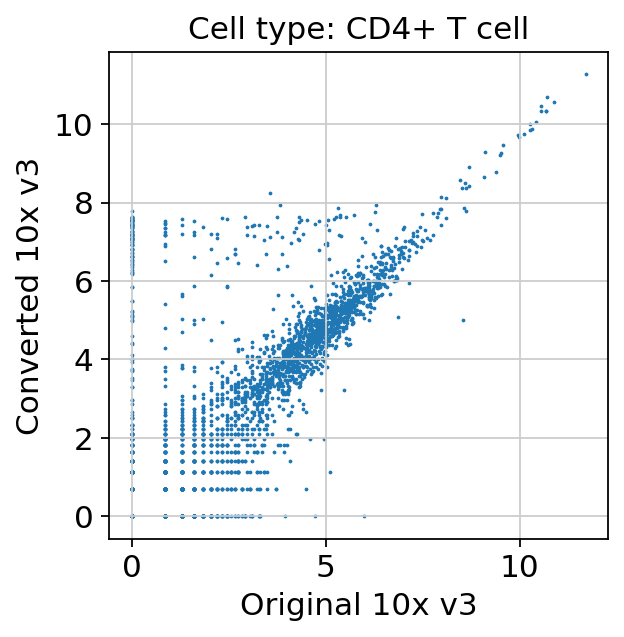

In [14]:
plt.scatter(np.log1p(a1_X_g), np.log1p(a2_X_g), s=0.5)

plt.title(f'Cell type: {cell_type}')
plt.xlabel('Original 10x v3')
plt.ylabel('Converted 10x v3')

In [15]:
r2 = r2_score(np.log1p(a1_X_g), np.log1p(a2_X_g))
print(f'sklearn.metrics.r2_score in log space:\t{r2}')

r2 = r2_score(a1_X_g, a2_X_g)
print(f'sklearn.metrics.r2_score:\t{r2}')

r2 = pearsonr(np.log1p(a1_X_g), np.log1p(a2_X_g))
print(f'scipy.stats.pearsonr in log space:\t{r2}')

r2 = pearsonr(a1_X_g, a2_X_g)
print(f'scipy.stats.pearsonr:\t{r2}')

sklearn.metrics.r2_score in log space:	0.6129069681160559
sklearn.metrics.r2_score:	0.8947297909639114
scipy.stats.pearsonr in log space:	PearsonRResult(statistic=0.8218278104535768, pvalue=0.0)
scipy.stats.pearsonr:	PearsonRResult(statistic=0.9789321725679584, pvalue=0.0)


In [ ]:

pearsonr(a1_X_g, a2_X_g)

PearsonRResult(statistic=0.9707901054951127, pvalue=0.0)

normalizing counts per cell
    finished (0:00:00)


/u/mallina1/envs/torch_jax2/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning:

Received a view of an AnnData. Making a copy.



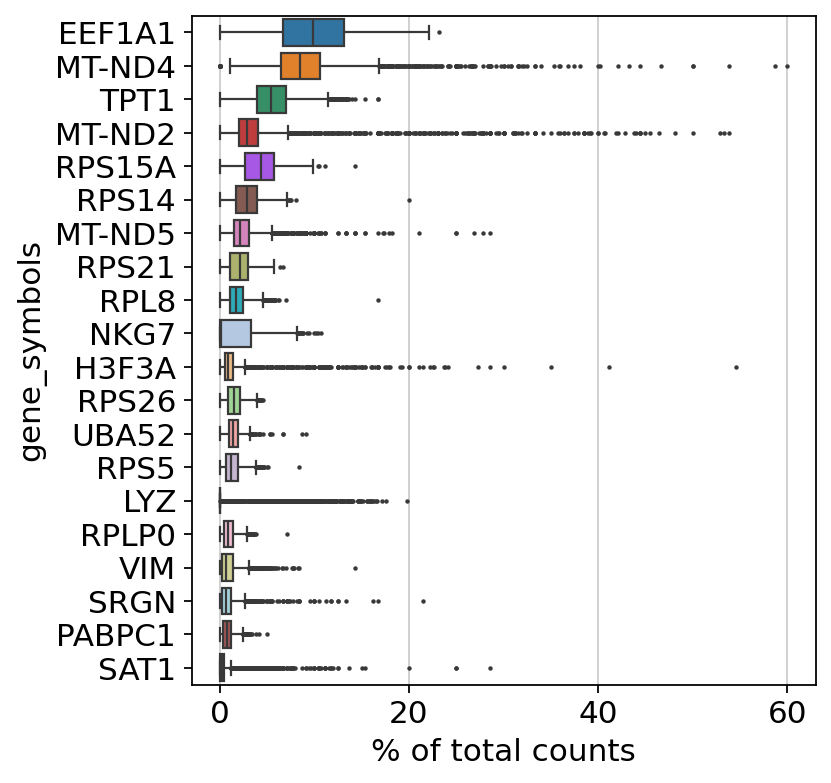

In [161]:
sc.pl.highest_expr_genes(orig_adata, n_top=20, gene_symbols='gene_symbols')

normalizing counts per cell
    finished (0:00:00)


/u/mallina1/envs/torch_jax2/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning:

Received a view of an AnnData. Making a copy.



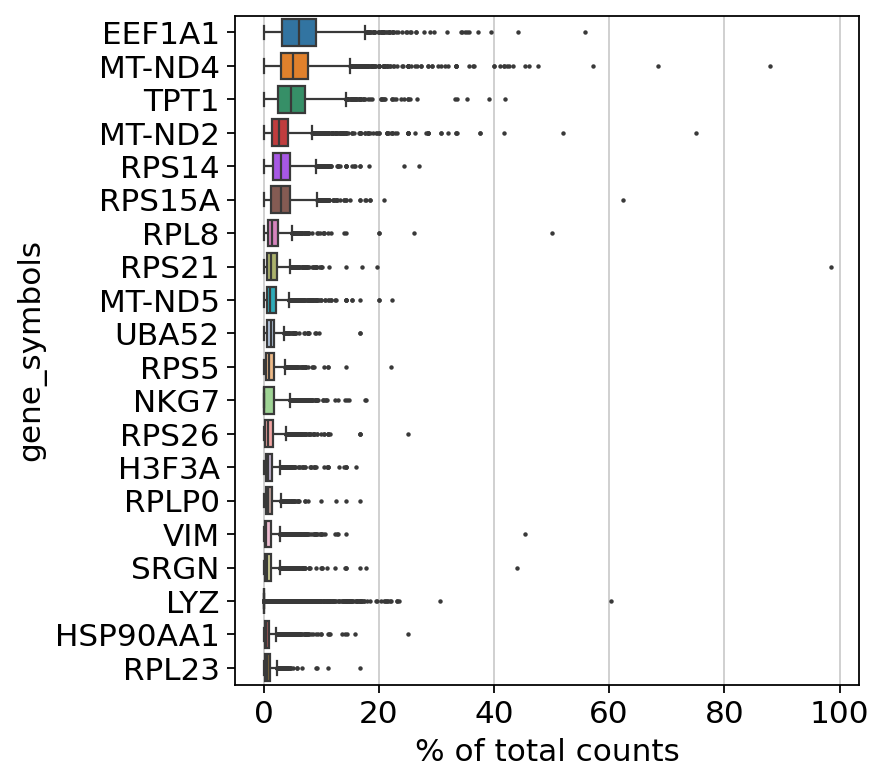

In [162]:
sc.pl.highest_expr_genes(conv_adata, n_top=20, gene_symbols='gene_symbols')

In [163]:
# sc.pp.filter_cells(orig_adata, min_genes=200)
# sc.pp.filter_genes(orig_adata, min_cells=3)
sc.pp.normalize_total(orig_adata, target_sum=1e4)
sc.pp.log1p(orig_adata)
sc.pp.highly_variable_genes(orig_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

orig_adata.raw = orig_adata.copy()
orig_adata = orig_adata[:, orig_adata.var.highly_variable]

sc.pp.neighbors(orig_adata, n_neighbors=10, n_pcs=40)
sc.tl.leiden(orig_adata, use_weights=True)
sc.tl.umap(orig_adata)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing neighbors
computing PCA
    with n_comps=40


/u/mallina1/envs/torch_jax2/lib/python3.10/site-packages/scanpy/tools/_utils.py:41: UserWarning:

You’re trying to run this on 349 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.



    finished (0:00:00)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
running Leiden clustering


/tmp/ipykernel_427134/2570407134.py:11: FutureWarning:

In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.



    finished: found 14 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:05)


In [164]:
# sc.pp.filter_cells(conv_adata, min_genes=200)
# sc.pp.filter_genes(conv_adata, min_cells=3)
sc.pp.normalize_total(conv_adata, target_sum=1e4)
sc.pp.log1p(conv_adata)
sc.pp.highly_variable_genes(conv_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

conv_adata.raw = conv_adata.copy()
conv_adata = conv_adata[:, conv_adata.var.highly_variable]

sc.pp.neighbors(conv_adata, n_neighbors=10, n_pcs=40)
sc.tl.leiden(conv_adata, use_weights=True)
sc.tl.umap(conv_adata)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing neighbors


computing PCA
    with n_comps=40


/u/mallina1/envs/torch_jax2/lib/python3.10/site-packages/scanpy/tools/_utils.py:41: UserWarning:

You’re trying to run this on 853 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.



    finished (0:00:00)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering


/u/mallina1/envs/torch_jax2/lib/python3.10/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



    finished: found 13 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:05)


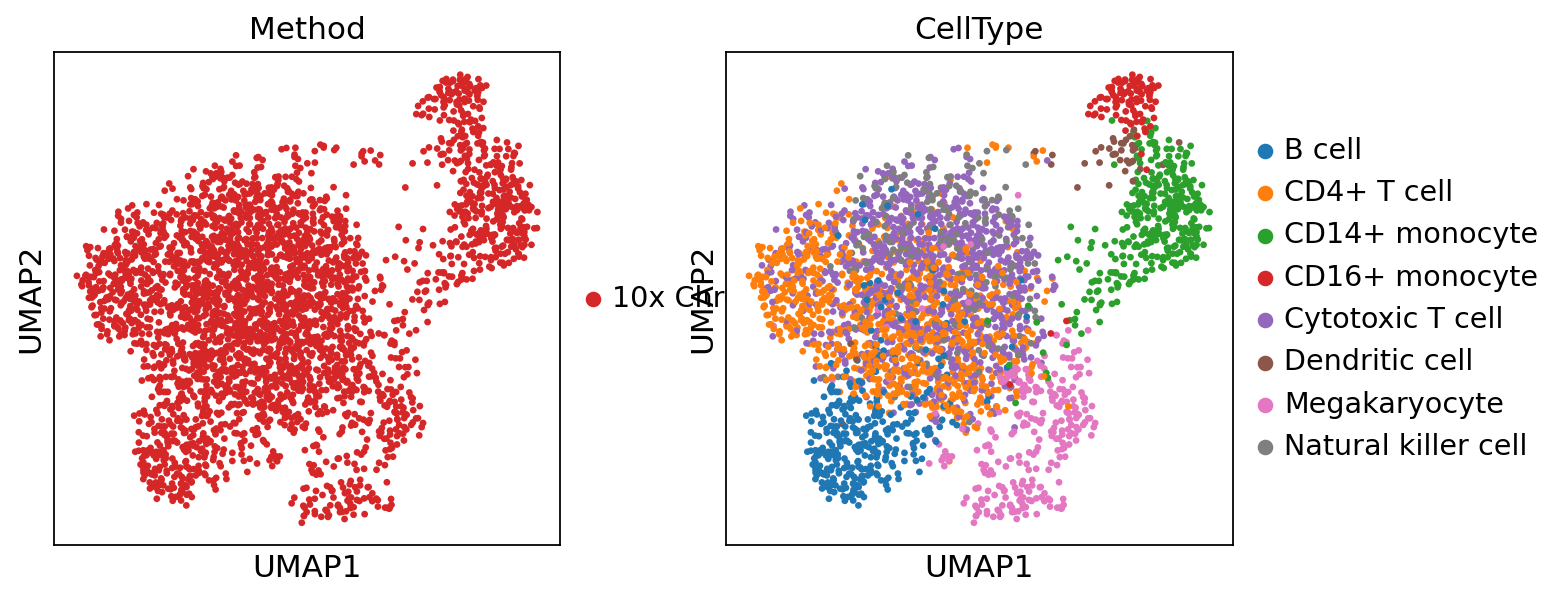

In [165]:
sc.pl.umap(orig_adata, color=["Method", "CellType"])

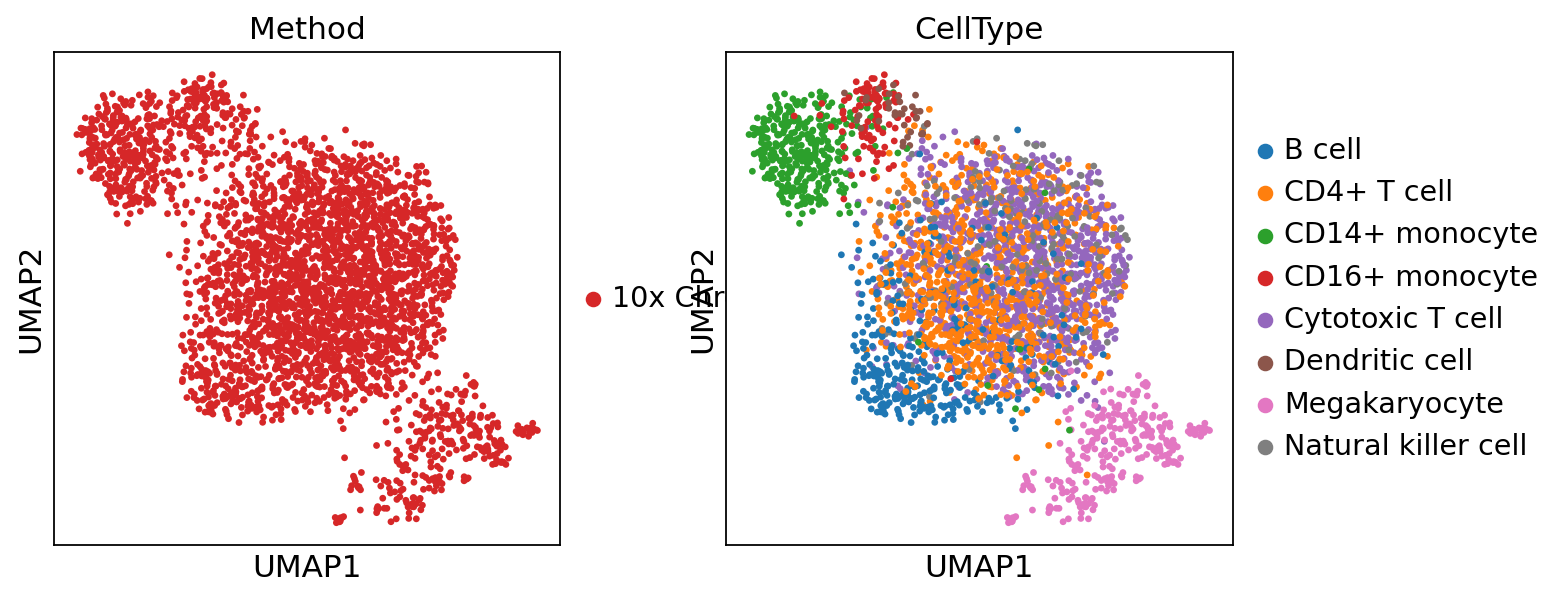

In [166]:
sc.pl.umap(conv_adata, color=["Method", "CellType"])